In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

(4, 1, 2)


Text(0.5, 1.0, 'what cv2.approxPolyDP found (Large circle)')

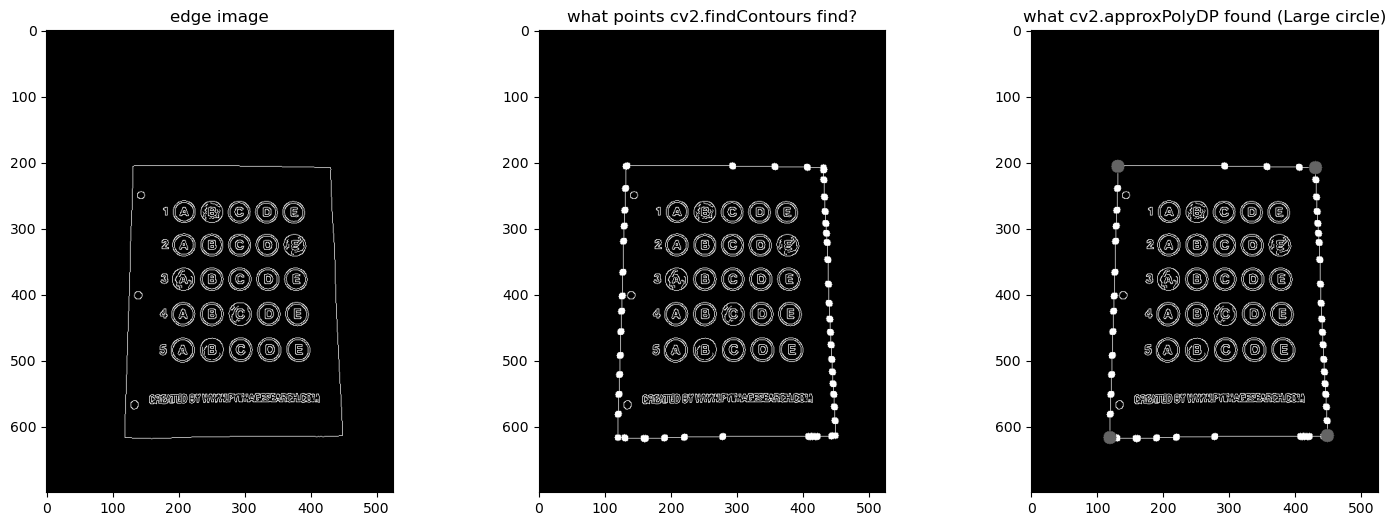

In [2]:
#1 Detect the exam paper in an image

image = cv2.imread("./omr_test_01.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(blurred, 50, 200)

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(edged, cmap="gray")
plt.title("edge image")

omr_contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
omr_contours = omr_contours[0]

# draw contour's points postion
edged_copy = edged.copy()
for i in range(len(omr_contours[0])):
    cv2.circle(edged_copy, omr_contours[0].squeeze()[i], 5, (255, 255, 255), -1)
# for i in range(len(omr_contours[0][0])):
    # cv2.circle(edged_copy, omr_contours[0][0].squeeze()[i], 5, (255, 255, 255), -1)
plt.subplot(132)
plt.imshow(edged_copy, cmap="gray")
plt.title("what points cv2.findContours find?")

# find rectangle
document_contour = 0
if len(omr_contours) > 0 :
    cnts = sorted(omr_contours, key=cv2.contourArea, reverse=True)

    for cnt in cnts:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
        
        
        if len(approx) == 4:
            document_contour = approx
            break

print(document_contour.shape)
for i in range(len(document_contour)):
    cv2.circle(edged_copy, document_contour.squeeze()[i], 10, (100, 100, 100), -1)
plt.subplot(133)
plt.imshow(edged_copy, cmap="gray")
plt.title("what cv2.approxPolyDP found (Large circle)")

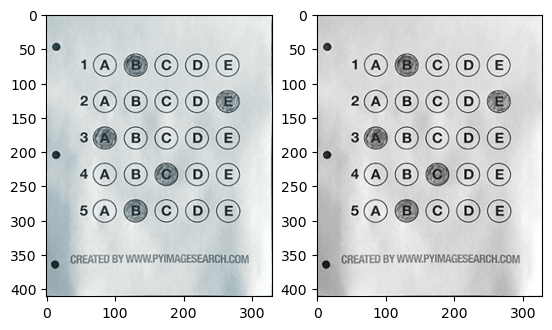

In [134]:
paper = four_point_transform(image, document_contour.reshape(4,2))
warped = four_point_transform(gray, document_contour.reshape(4,2))

plt.subplot(121)
plt.imshow(paper)
plt.subplot(122)
plt.imshow(warped, cmap="gray")

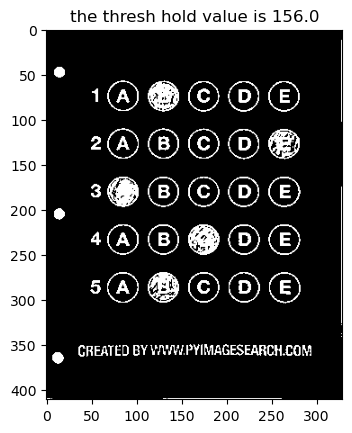

In [23]:
# the OTSU caculation
#  least_class_var = max_float_val
#  least_tv = 0
#  for tv in all values(0,255):
#   g1,g2 = divide two group by this tv
#   w1,w2 = calculate_weights(g1,g2) # this can be vary. for simplicity, I choose just sum of probability for each groups elements. 
#                                    # if [(1,1),(2,2),(3,3),(4,4)] for val,occurs and tv is 2, then w1 = 3/10 and w2 = 7/10
#   mg1,mg2 = calculate_mean(g1,g2)
#   vg1,vg2 = calculate_variance(g1,mg1,g2,mg2)
#   cur_class_var = |w1*vg1 - w2*vg2|
#   least_class_var = min(cur_class_var, least_class_var)
#   if least_class_var changed:
#    least_tv = tv

# cv2.THRESH_BINARY_INV
#  this just invert max,min value. for example, if objects are black, then convert it to white and vice versa
tv, thresh = cv2.threshold(warped, 0, 255,
	 cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
np.shape(thresh)

plt.title(f"the thresh hold value is {tv}")
plt.imshow(thresh, cmap="gray")

(92,)
(2, 1, 2)


c:\Users\c\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


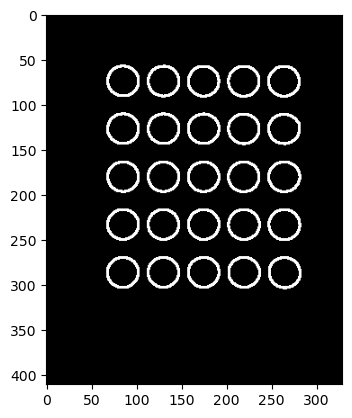

In [73]:
def run_once(f):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.has_run = True
            return f(*args, **kwargs)
    wrapper.has_run = False
    return wrapper

@run_once
def print_once(a):
    print(a)

# finds all questioned circles and store it on questioned_cnts

threshed_cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
threshed_cnts = threshed_cnts[0]
print(np.shape(threshed_cnts))
questioned_cnts = []

for c in threshed_cnts:
    print_once(np.shape(c))
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if w>= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questioned_cnts.append(c)


black_canvas = np.zeros(thresh.shape)
bc_with_cnt = cv2.drawContours(black_canvas, questioned_cnts, -1, 255, 2)

plt.imshow(bc_with_cnt, cmap="gray")

In [117]:
# sort circles on top-bottom, left-right order
# result is sorted_qcnts

qcnts = []
for i, c in enumerate(questioned_cnts):
    x,y,_,_ = cv2.boundingRect(c)
    qcnts.append((x,y,i))

qcnts.sort(key=lambda c: [c[1],c[0]])
sorted_cnts_idxs = [i for _,_,i in qcnts]

sorted_qcnts = []
for i in sorted_cnts_idxs:
    sorted_qcnts.append(questioned_cnts[i])




[1, 9, 10, 17, 21]


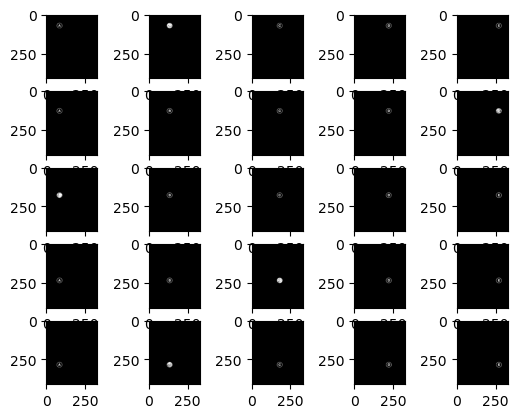

In [118]:
# fill the checked circles and show it on plt.imshow

threshhold_filled = 600

# plt.subplot(551)
# plt.imshow(thresh, cmap="gray")

answers = []
for i, c in enumerate(sorted_qcnts):
    masking_img = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(masking_img, [c], -1, 255, -1)
    masked_img = cv2.bitwise_and(thresh, thresh, mask=masking_img)
    plt.subplot(5,5,1+i)
    plt.imshow(masked_img, cmap="gray")
    total_val = cv2.countNonZero(masked_img)
    if total_val > threshhold_filled:
        answers.append(i)
print(answers)


In [120]:
# adapt ANSWER format to my program foramt

ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

answer_to_flatten = [ANSWER_KEY[i]+i*5 for i in ANSWER_KEY]

print(answer_to_flatten)

[1, 9, 10, 18, 21]


5
80.0


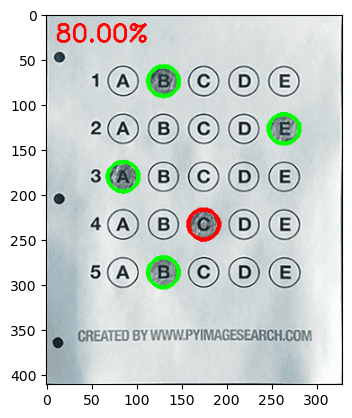

In [138]:
# draw answer on test page and calculate the answer

threshhold_filled = 600

total_questions_nums = len(ANSWER_KEY)
correct_questions = 0
print(total_questions_nums)
graded_test = paper.copy()

for i, c in enumerate(sorted_qcnts):
    masking_img = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(masking_img, [c], -1, 255, -1)
    masked_img = cv2.bitwise_and(thresh, thresh, mask=masking_img)
    total_val = cv2.countNonZero(masked_img)

    if total_val > threshhold_filled :
        color = [255, 0, 0]
        if i in answer_to_flatten :
            correct_questions += 1
            color = [0,255, 0]
        cv2.drawContours(graded_test,[c], -1, color, 3)

score = (correct_questions/total_questions_nums)*100
print(score)
cv2.putText(graded_test, f"{score:.2f}%", (10,30),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2) 

plt.imshow(graded_test)